In [1]:
import pandas as pd
from collections import defaultdict
import datetime
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")

In [2]:
def read_csv_data(path):
    """
    Reads the csv file from the given path 
    and returns a pandas dataframe.

    Input => str : file path
    Output => pd.DataFrame : data from the file
    """
    assert isinstance(path, str) and path[-3:] == "csv"

    try:
        df = pd.read_csv(path)
    except:
        raise FileNotFoundError
    return df

In [3]:
texas_housing_data = read_csv_data("dataMSA_full.csv")
texas_housing_data.head()

,Area,Year,Quarter,Overall_hpi,Overall_YoY,Low_hpi,Low_YoY,Mid_hpi,Mid_YoY,High_hpi,High_YoY
0,Austin-Round Rock,1999,1,100.000000,NaN,100.000000,NaN,100.000000,NaN,100.000000,NaN
1,Austin-Round Rock,1999,2,105.047433,NaN,109.557976,NaN,103.048818,NaN,102.705730,NaN
2,Austin-Round Rock,1999,3,105.986409,NaN,106.474285,NaN,106.222662,NaN,105.222010,NaN
3,Austin-Round Rock,1999,4,108.343279,NaN,114.444291,NaN,104.031959,NaN,106.144577,NaN
4,Austin-Round Rock,2000,1,113.774119,0.137741,113.401894,0.134019,111.383312,0.113833,114.878674,0.148787


In [4]:
texas_housing_data = texas_housing_data[["Area", "Year", "Quarter", "Overall_hpi"]]
texas_housing_data.head()

,Area,Year,Quarter,Overall_hpi
0,Austin-Round Rock,1999,1,100.000000
1,Austin-Round Rock,1999,2,105.047433
2,Austin-Round Rock,1999,3,105.986409
3,Austin-Round Rock,1999,4,108.343279
4,Austin-Round Rock,2000,1,113.774119


In [5]:
texas_cpi_data = read_csv_data("CPI_TX.csv")
texas_cpi_data.head()

,Year,CPI
0,1914,9.500
1,1915,9.500
2,1916,9.617
3,1917,11.092
4,1918,13.425


In [6]:
texas_areas = texas_housing_data["Area"].unique()

In [7]:
# Create a date column
texas_housing_data["Date"] = texas_housing_data["Year"].astype(str) + "-" + ((texas_housing_data["Quarter"]-1)*3 + 1).astype(str) + "-01"
texas_housing_data["Date"] = pd.to_datetime(texas_housing_data["Date"])

In [8]:
def plot_time_series(x_values, y_values, x_label="", y_label="", title=""):
    """
    Plot a time series graph for given 
    values of x and y
    """
    assert isinstance(x_values, pd.Series) and isinstance(y_values, pd.Series)
    assert x_values.shape == y_values.shape

    # Adjusting the figure size
    fig = plt.subplots(figsize=(8, 5))

    # Creating a plot
    plt.plot(x_values.to_numpy(), y_values.to_numpy())

    # Adding a plot title and customizing its font size
    plt.title(title, fontsize=20)

    # Adding axis labels and customizing their font size
    plt.xlabel(x_label, fontsize=15)
    plt.ylabel(y_label, fontsize=15)

    # Rotaing axis ticks and customizing their font size
    plt.xticks(fontsize=15)

    plt.show()

In [9]:
# Create a new data structure
texas_cpi = {}
for i, d in texas_cpi_data.iterrows():
    texas_cpi[d["Year"]] = d["CPI"]

In [10]:
def get_normalized_hpi(df, base):
    return (df["Overall_hpi"]*base)/texas_cpi[df["Year"]]

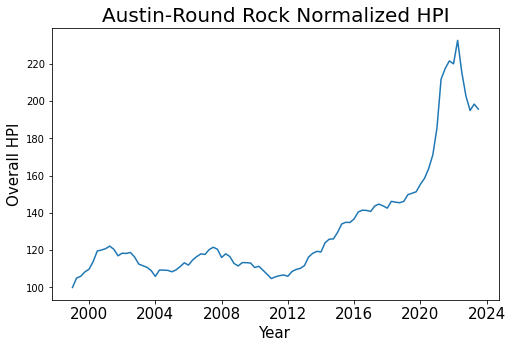

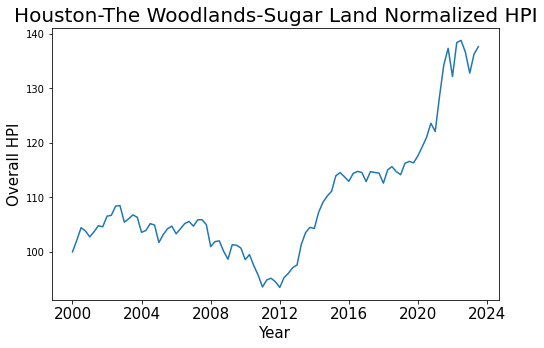

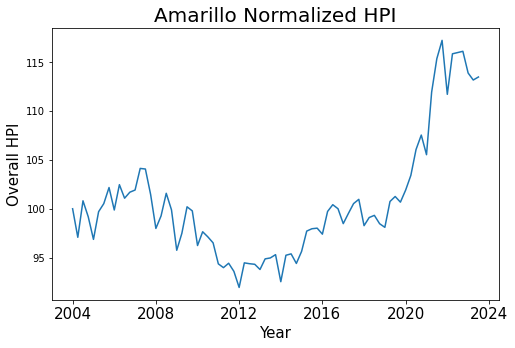

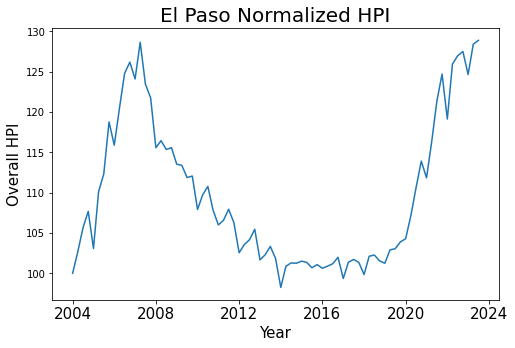

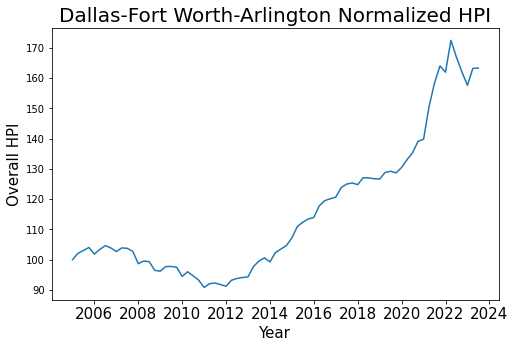

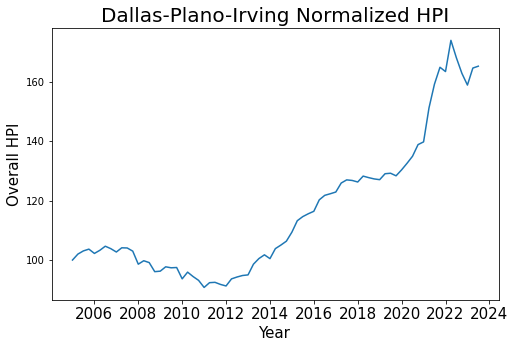

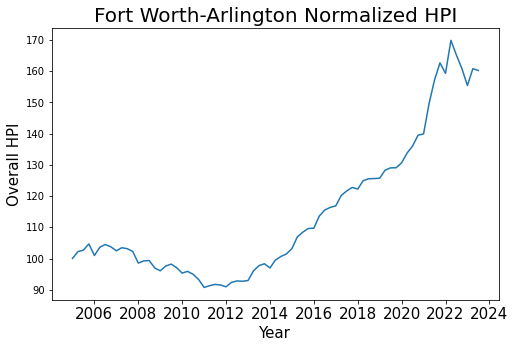

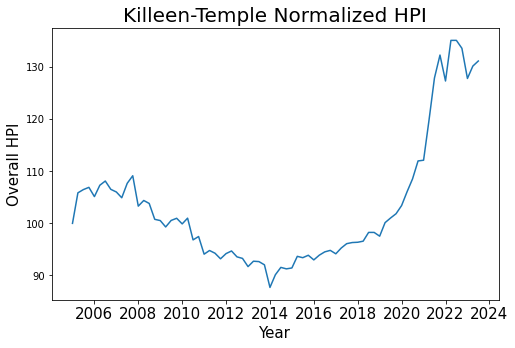

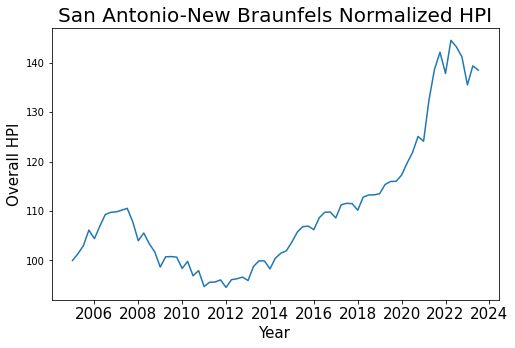

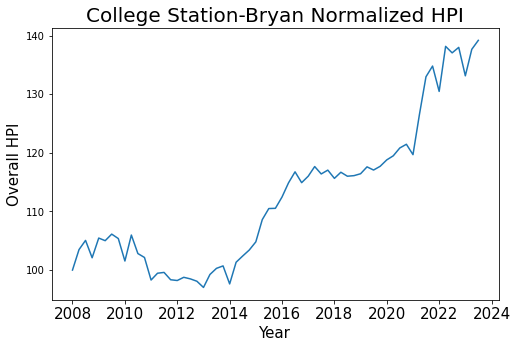

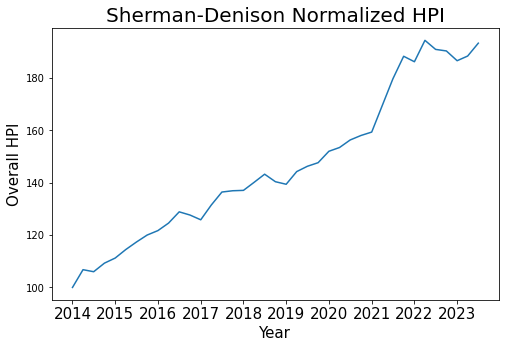

In [11]:
for area in texas_areas:
    area_df = texas_housing_data.loc[texas_housing_data["Area"] == area]
    base_cpi = texas_cpi[min(area_df["Year"])]
    area_df["Normalized_hpi"] = area_df.apply(get_normalized_hpi, axis=1, base=base_cpi)
    plot_time_series(area_df["Date"], area_df["Normalized_hpi"], "Year", "Overall HPI", area+" Normalized HPI")

In [12]:
texas_disaster_data = read_csv_data("events-TX-1980-2023.csv")
texas_disaster_data = texas_disaster_data[["Name","Year Begin","Quarter Begin","Year End","Quarter End","Total Cost"]]
texas_disaster_data.head()

,Name,Year Begin,Quarter Begin,Year End,Quarter End,Total Cost
0,Hurricane Allen (August 1980),1980,3,1980,3,2177.2
1,Central/Eastern Drought/Heat Wave (Summer-Fall...,1980,2,1980,4,39679.2
2,"Severe Storms, Flash Floods, Hail, Tornadoes (...",1981,2,1981,2,1376.9
3,"Midwest/Southeast/Northeast Winter Storm, Cold...",1982,1,1982,1,2158.1
4,Midwest/Plains/Southeast Tornadoes (April 1982),1982,2,1982,2,1565.6


In [13]:
disaster_count = defaultdict(int)
disaster_cost = defaultdict(list)

for i, d in texas_disaster_data.iterrows():
    year_begin = d["Year Begin"]
    year_end = d["Year End"]
    quarter_begin = d["Quarter Begin"]
    quarter_end = d["Quarter End"]
    cost = d["Total Cost"]
    if year_begin == year_end:
        if quarter_begin == quarter_end:
            disaster_count[(year_begin, quarter_begin)] += 1
            disaster_cost[(year_begin, quarter_begin)].append(cost)
        else:
            n_quarters = quarter_end - quarter_begin + 1
            for q in range(quarter_begin, quarter_end+1):
                disaster_count[(year_begin, q)] += 1
                disaster_cost[(year_begin, q)].append(cost/n_quarters)
    else:
        curr_year = year_begin
        curr_quarter = quarter_begin
        n_quarters = (year_end - year_begin + 1)*4 - quarter_begin + quarter_end - 3
        while not ((curr_year == year_end) and (curr_quarter == quarter_end)):
            disaster_count[(curr_year, curr_quarter)] += 1
            disaster_cost[(curr_year, curr_quarter)].append(cost/n_quarters)
            if curr_quarter == 4:
                curr_quarter = 1
                curr_year += 1
                continue
            curr_quarter += 1

In [14]:
disaster_count

defaultdict(int,
            {(1980, 3): 2,
             (1980, 2): 1,
             (1980, 4): 1,
             (1981, 2): 1,
             (1982, 1): 1,
             (1982, 2): 2,
             (1983, 3): 1,
             (1983, 4): 1,
             (1985, 1): 1,
             (1988, 2): 1,
             (1988, 3): 1,
             (1989, 2): 3,
             (1989, 3): 1,
             (1989, 4): 2,
             (1990, 2): 1,
             (1992, 1): 1,
             (1992, 2): 1,
             (1992, 4): 1,
             (1993, 1): 1,
             (1994, 1): 1,
             (1994, 2): 2,
             (1994, 4): 2,
             (1994, 3): 1,
             (1995, 2): 2,
             (1995, 3): 1,
             (1996, 1): 2,
             (1996, 2): 1,
             (1996, 3): 1,
             (1997, 1): 1,
             (1997, 4): 1,
             (1998, 3): 2,
             (1998, 2): 1,
             (1998, 4): 1,
             (1999, 1): 1,
             (1999, 2): 1,
             (2000, 1): 2,
           

In [15]:
disaster_cost

defaultdict(list,
            {(1980, 3): [2177.2, 13226.4],
             (1980, 2): [13226.4],
             (1980, 4): [13226.4],
             (1981, 2): [1376.9],
             (1982, 1): [2158.1],
             (1982, 2): [1565.6, 1540.5],
             (1983, 3): [9210.0],
             (1983, 4): [6318.5],
             (1985, 1): [2444.1],
             (1988, 2): [26605.05],
             (1988, 3): [26605.05],
             (1989, 2): [1373.3, 1450.8, 2542.7000000000003],
             (1989, 3): [2542.7000000000003],
             (1989, 4): [2542.7000000000003, 1659.1],
             (1990, 2): [2396.3],
             (1992, 1): [1777.6],
             (1992, 2): [2109.2],
             (1992, 4): [1425.9],
             (1993, 1): [11883.3],
             (1994, 1): [6295.1],
             (1994, 2): [2058.9, 502.6666666666667],
             (1994, 4): [2060.0, 502.6666666666667],
             (1994, 3): [502.6666666666667],
             (1995, 2): [1167.3, 11082.7],
             (1995, 3): 

In [16]:
# Calculate average cost for each quarter
avg_disaster_cost = defaultdict(float)
for date in disaster_cost:
    avg_disaster_cost[date] = sum(disaster_cost[date])/len(disaster_cost[date])
avg_disaster_cost

defaultdict(float,
            {(1980, 3): 7701.799999999999,
             (1980, 2): 13226.4,
             (1980, 4): 13226.4,
             (1981, 2): 1376.9,
             (1982, 1): 2158.1,
             (1982, 2): 1553.05,
             (1983, 3): 9210.0,
             (1983, 4): 6318.5,
             (1985, 1): 2444.1,
             (1988, 2): 26605.05,
             (1988, 3): 26605.05,
             (1989, 2): 1788.9333333333334,
             (1989, 3): 2542.7000000000003,
             (1989, 4): 2100.9,
             (1990, 2): 2396.3,
             (1992, 1): 1777.6,
             (1992, 2): 2109.2,
             (1992, 4): 1425.9,
             (1993, 1): 11883.3,
             (1994, 1): 6295.1,
             (1994, 2): 1280.7833333333333,
             (1994, 4): 1281.3333333333333,
             (1994, 3): 502.6666666666667,
             (1995, 2): 6125.0,
             (1995, 3): 1978.2,
             (1996, 1): 3582.2166666666667,
             (1996, 2): 1188.3333333333333,
             (1

In [17]:
# Create a new DataFrame for Date and Average Cost for each quarter
events_df = pd.DataFrame(avg_disaster_cost.items(), columns=["Quarter", "Cost"])
events_df.head()

,Quarter,Cost
0,"(1980, 3)",7701.8
1,"(1980, 2)",13226.4
2,"(1980, 4)",13226.4
3,"(1981, 2)",1376.9
4,"(1982, 1)",2158.1


In [43]:
# Add a Date column to the dataframe
events_df["Date"] = events_df.Quarter.str[0].astype(str) + "-" + ((events_df.Quarter.str[1] - 1)*3 + 1).astype(str) + "-01"
events_df["Date"] = pd.to_datetime(events_df["Date"])
events_df = events_df.sort_values("Date")
events_df.head()

,Quarter,Cost,Date
1,"(1980, 2)",13226.4,1980-04-01
0,"(1980, 3)",7701.8,1980-07-01
2,"(1980, 4)",13226.4,1980-10-01
3,"(1981, 2)",1376.9,1981-04-01
4,"(1982, 1)",2158.1,1982-01-01


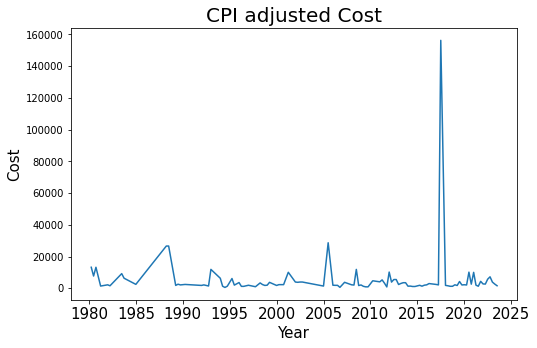

In [31]:
plot_time_series(events_df["Date"], events_df["Cost"], "Year", "Cost", "CPI adjusted Cost")

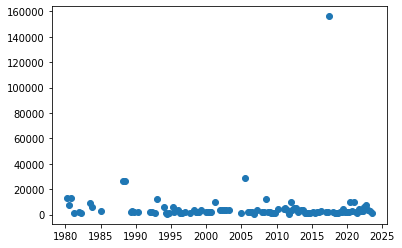

In [32]:
plt.scatter(events_df["Date"].to_numpy(), events_df["Cost"].to_numpy())
plt.show()

In [52]:
def plot_events_and_hpi(x_values1, x_values2, y_values1, y_values2, x_label="", y_label="", title=""):
    """
    Plot 2 time series graphs for given 
    values of x1, x2 and y
    """
    assert isinstance(x_values1, pd.Series) and isinstance(x_values2, pd.Series) and isinstance(y_values1, pd.Series) and isinstance(y_values2, pd.Series)
    assert x_values1.shape == y_values1.shape and x_values2.shape == y_values2.shape

    # Adjusting the figure size
    fig = plt.subplots(figsize=(8, 5))

    # Creating a plot
    plt.plot(x_values1.to_numpy(), y_values1.to_numpy())
    plt.plot(x_values2.to_numpy(), y_values2.to_numpy())

    # Adding a plot title and customizing its font size
    plt.title(title, fontsize=20)

    # Adding axis labels and customizing their font size
    plt.xlabel(x_label, fontsize=15)
    plt.ylabel(y_label, fontsize=15)

    # Rotaing axis ticks and customizing their font size
    plt.xticks(fontsize=15)

    plt.show()

In [63]:
def get_normalized_cost(df, base):
    return 0 + (df["Cost"]*100)/base

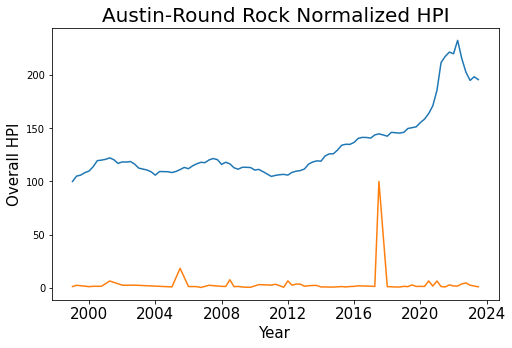

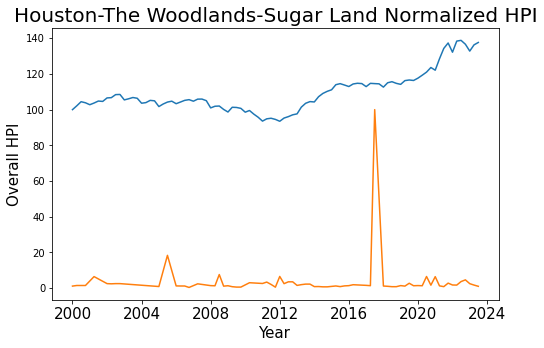

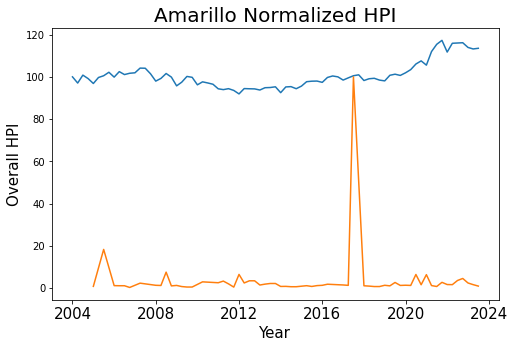

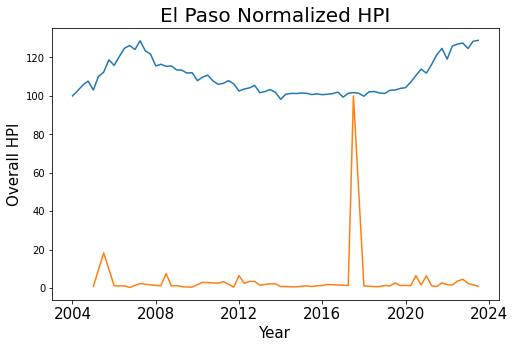

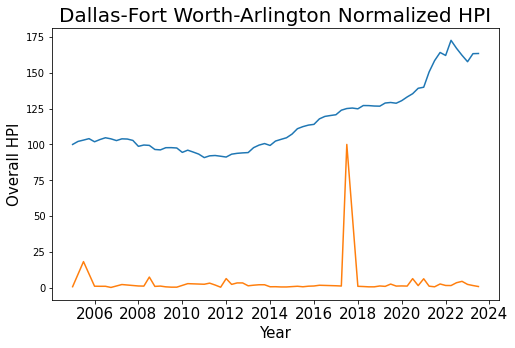

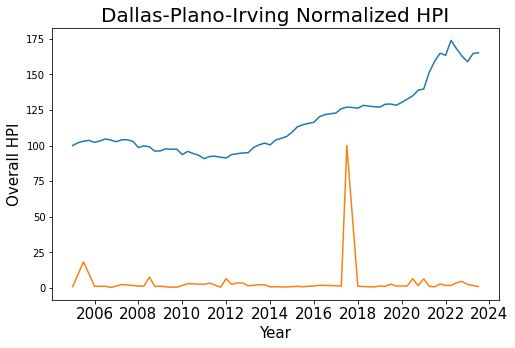

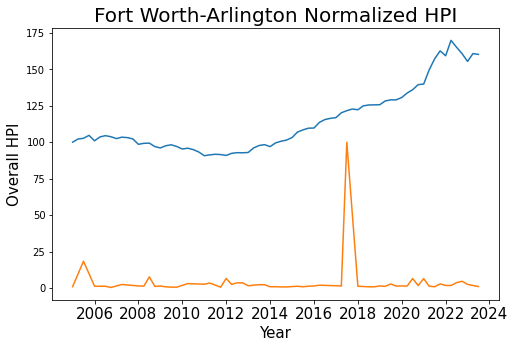

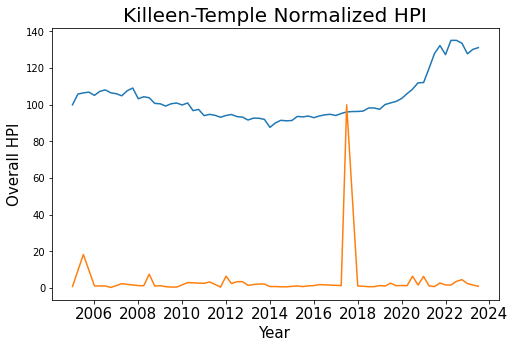

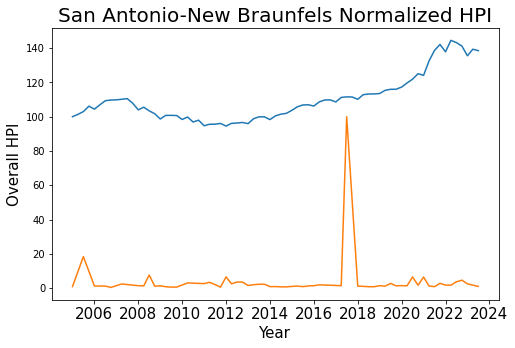

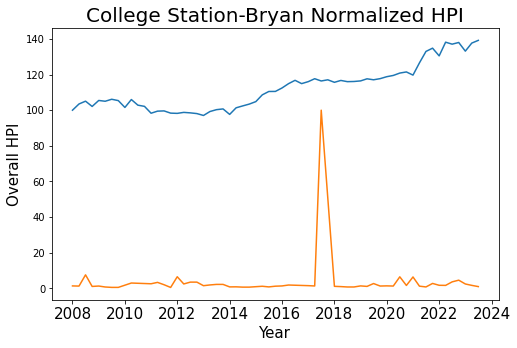

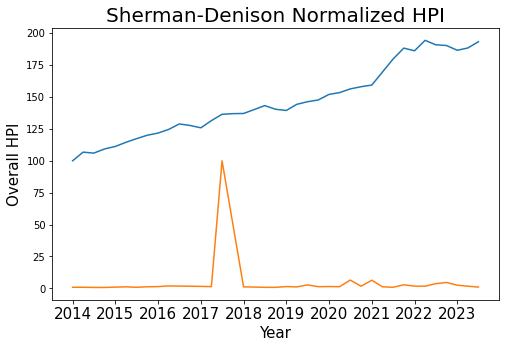

In [64]:
for area in texas_areas:
    area_df = texas_housing_data.loc[texas_housing_data["Area"] == area]
    base_cpi = texas_cpi[min(area_df["Year"])]
    area_df["Normalized_hpi"] = area_df.apply(get_normalized_hpi, axis=1, base=base_cpi)
    temp_df = events_df.loc[(events_df["Quarter"].str[0] >= min(area_df["Year"])) & (events_df["Quarter"].str[0] <= max(area_df["Year"]))]
    base_cost = temp_df.loc[temp_df["Cost"] == max(temp_df["Cost"])]["Cost"].values[0]
    temp_df["Normalized_cost"] = temp_df.apply(get_normalized_cost, axis=1, base=base_cost)
    plot_events_and_hpi(area_df["Date"], temp_df["Date"], area_df["Normalized_hpi"], temp_df["Normalized_cost"], "Year", "Overall HPI", area+" Normalized HPI")